# ROC and AUC

In [1]:
from sklearn.datasets import load_breast_cancer
dataset = load_breast_cancer()
import pandas as pd

def decision_boundary_y(x, coefs, intercept):
    coef_pair = coefs[0]
    return (coef_pair[0]/coef_pair[1])*x + intercept[0]/coef_pair[1]

X = dataset['data']
y = dataset['target']
df = pd.DataFrame(X, columns = dataset['feature_names'])
df['is_cancerous'] = y

scoped_df = df[['mean area', 'mean concavity']]

from sklearn.linear_model import LogisticRegression


model = LogisticRegression()
model.fit(scoped_df, y)

area_values = list(range(500, 1000, 5))
boundaries = [decision_boundary_y(idx, model.coef_, model.intercept_) for idx in area_values]

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [3]:
mean_area = df['mean area']
y = df['is_cancerous']


from sklearn.linear_model import LinearRegression, LogisticRegression
lin_model = LinearRegression()
X = mean_area.to_numpy().reshape(-1, 1)
lin_model.fit(X, y)

log_model = LogisticRegression()
log_model.fit(X, y)

import numpy as np
x_inputs = np.array(list(range(0, 1500))).reshape(-1, 1)
x_inputs_log = np.array(list(range(500, 700))).reshape(-1, 1)
lin_predictions = lin_model.predict(x_inputs)
logistic_predictions = log_model.decision_function(x_inputs_log)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Introduction

Previously, we discussed how we can use log loss to determine how well a given hypothesis function is doing.  As we know log loss, allocates close to zero loss when we are confident and correct, and exacts a high penalty for confident incorrect predictions.

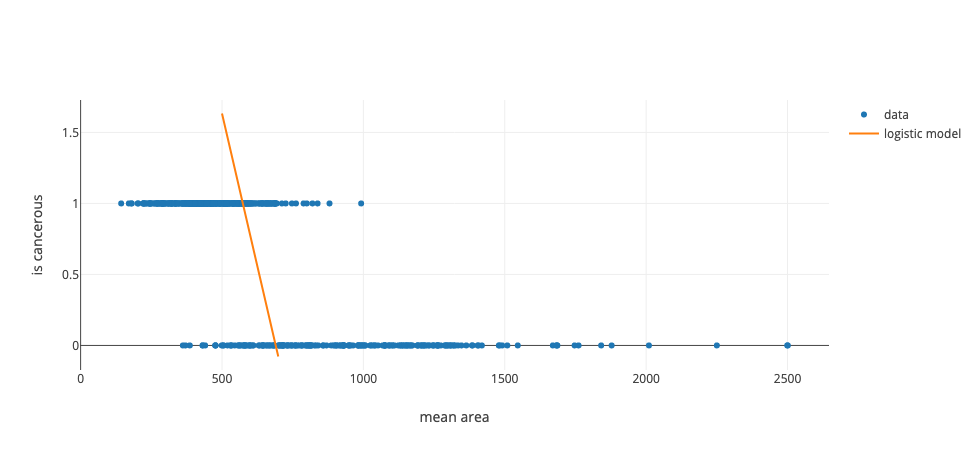

In [4]:
from graph import trace_values, plot

mean_area = df['mean area']
y = df['is_cancerous']

data_trace = trace_values(mean_area, y)

lin_predictions_trace = trace_values(x_inputs.flatten(), lin_predictions, mode = 'lines', name = 'linear model')
logisitic_predictions_trace = trace_values(x_inputs_log.flatten(), logistic_predictions, mode = 'lines', name = 'logistic model')

plot([data_trace,  logisitic_predictions_trace], {'xaxis': {'title': 'mean area'}, 'yaxis': {'title': 'is cancerous'}})

Now if we break down how a loss occurs with our classifier, we can say there are two factors contributing to our loss.

* Threshold
One of these factors is the threshold of our classifier.  We can think of this as the placement of the orange line.  For example if we slid our orange line all of the way to the left, we would classify everything as being benign.  Choosing different thresholds lead to different accuracy scores (the percentage of observations that we classify correctly).

* Separability
The other component is the separability of our observations.  This is essentially the order of our datapoints.  If we have all of the negative events to the left of all of the positive datapoints, then we could imagine choosing a threshold that separates all of our negative observations from our positive observations.  However, if our observations are not separable, then we cannot avoid error, regardless of our threshold.

### Our changing thresholds

If we think about it,it is not too difficult to change our threshold for classifying something positive or negative.  Remember that our threshold is just the sign of our score.  If we wish classify more events as positive, we can simply add a constant to our decision function.

In [9]:
log_model.decision_function(X)[:7]

array([-2.67485155, -5.46965257, -4.41192787,  2.61291196, -5.22027032,
        1.83036768, -3.01022767])

The other thing to note is that even if fitting our function already fits our data in a way log loss, there may be reasons for wanting to modify this threshold.  For example, if we are classifying emails as spam or not, we could imagine that it's more costly to misclassify as spam and thus we miss the email, and less costly to misclassify an email as not spam, and causing us to click delete.  So we could want to subtract from our score, so that we can classify more emails as authentic rather than spam. 

So we can slide our thresholds up and down depending on how much we weight false negatives over false negatives.

### Our changing separabilities

While the threshold that we choose can change on broader objectives and is can be modified, the way that we value is separability is more constant: we always want our classifier to separate our data as much as possible.  If our data is not separable, then we will suffer that regardless of the threshold we choose.

Of course the separability from our model is dependent on our model's quality.  For example, in our simple model above we see that mean area does a fairly good job of separating our positive data from our negative.  The cancerous observations tend to be more to the left than the benign observations.  And if we add mean concavity we gain further separability.  

### Evaluating Separability

We'd like to find a metric that measures how well our model separates our data into the respective classes.  For this, we can use ROC -- the receiver operating curve.  The ROC curve measures probability of observations pairs to be correctly ordered by our model.


Let's see how it works by way of example.  Assume that our model has the following.

[(462.9, 1),
 (541.8, 1),
 (664.7, 0),
 (462.0, 1),
 (596.6, 1),
 (392.0, 1),
 (1174.0, 0)]

In [95]:
paired_values = list(zip(mean_area, y))
sorted_pairs = sorted(paired_values, key=lambda x: x[0])
paired_subset = sorted_pairs[383:390]
mean_areas = [pair[0] for pair in paired_subset]
labels = [pair[1] for pair in paired_subset]

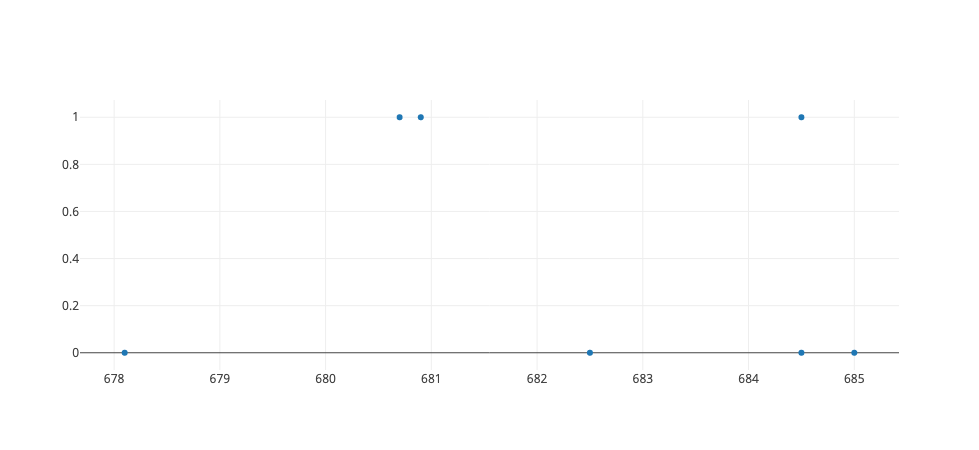

In [96]:
data_trace = trace_values(mean_areas, labels)
plot([data_trace])

Let's calculate ROC on the subset of our data.

In [99]:
positive_count = 0
x_values = list(range(0, len(sorted_pairs)))
y_values = []

for _, label in paired_subset:
    if label == 1:
        positive_count += 1
    y_values.append(positive_count)

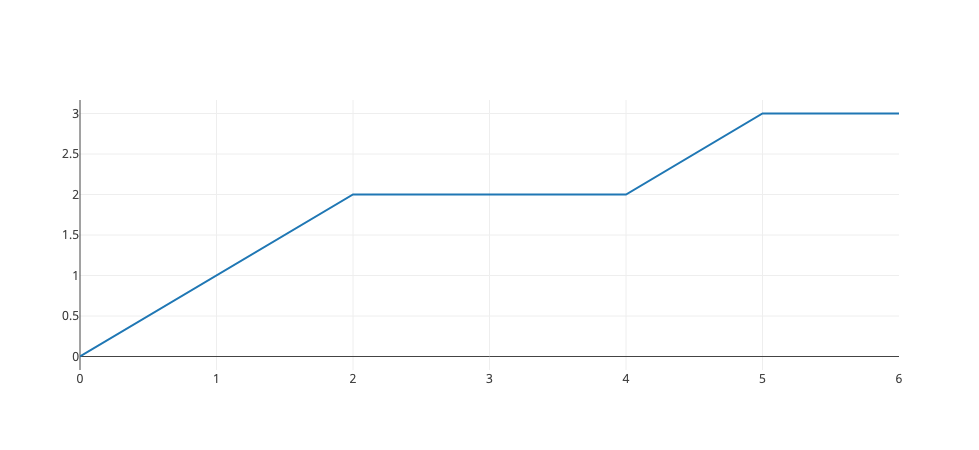

In [100]:
trace = trace_values(x_values, y_values, mode = 'lines')
plot([trace])

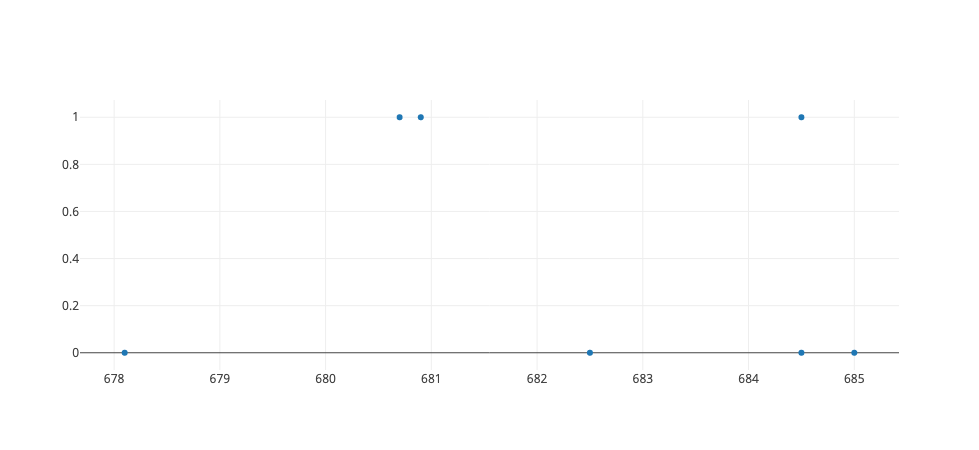

In [101]:
data_trace = trace_values(mean_areas, labels)
plot([data_trace])

We can begin to see what happened.  Everytime we encountered a new positive label, we increased the y value of our line.  Now imagine if we perfectly separated our data, and all of the positive labels occurred first.  Then our ROC curve would go all of the way vertically, and then all of the way horizontally.  It would take up the entire graph.  Here, our positive and negative observations are mixed.  We can see that we continue to travel horizontal distances before capturing all of the vertical space.  This results in a lower area under the curve for our ROC curve.

To determine how well we classify our data, we simply divide the area under the curve by the entire area of our graph.  So here, we would take our area and divide it by 3x6 = 18, the largest possible area under the curve.

### Using a baseline

A diagonal line would be our baseline for the ROC.